[[43365.43396226415, 52595.92452830189, 52967.84905660377, 72815.09433962264, 76872.45283018867, 78732.07547169812], [43365.43396226415, 52595.92452830189, 52967.84905660377, 72815.09433962264, 76872.45283018867, 78732.07547169812], [43365.43396226415, 52595.92452830189, 52967.84905660377, 72815.09433962264, 76872.45283018867, 78732.07547169812], [43365.43396226415, 52595.92452830189, 52967.84905660377, 72815.09433962264, 76872.45283018867, 78732.07547169812], [43365.43396226415, 52595.92452830189, 52967.84905660377, 72815.09433962264, 76872.45283018867, 78732.07547169812], [43365.43396226415, 52595.92452830189, 52967.84905660377, 72815.09433962264, 76872.45283018867, 78732.07547169812], [43365.43396226415, 52595.92452830189, 52967.84905660377, 72815.09433962264, 76872.45283018867, 78732.07547169812], [43365.43396226415, 52595.92452830189, 52967.84905660377, 72815.09433962264, 76872.45283018867, 78732.07547169812], [43365.43396226415, 52595.92452830189, 52967.84905660377, 72815.0943396

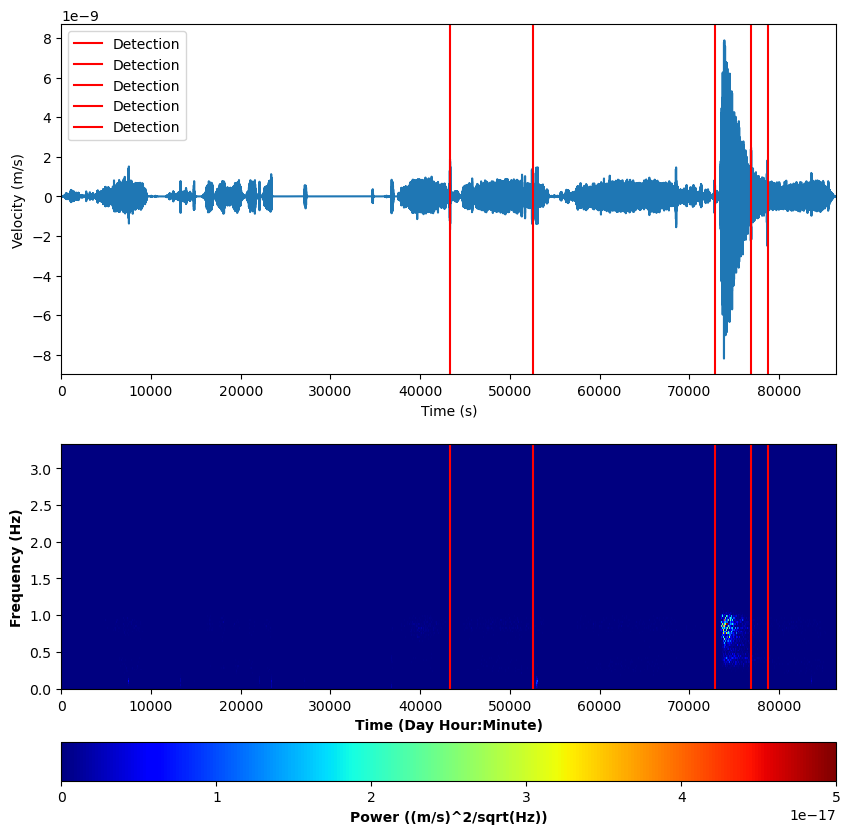

In [4]:
from scipy import signal
from matplotlib import cm
import numpy as np
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import csv

# TUNING PARAMETERS
MAX_GAP = 500  # Maximum time between 
FILTER_MIN_FREQ = 0.5
FILTER_MAX_FREQ = 1.0
CUTOFF_PERCENT = 0.4


def iterate_through_files(directory_str):
    directory = os.fsencode(directory_str)

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".mseed"): 
            run_algo(directory_str, filename)
            continue


def cluster_detect(poi_by_freq):
    cluster_mins = []
    print(poi_by_freq)
    for freq in poi_by_freq:
        temp_mins = continuity_test(freq)
        # print("Temp_mins", temp_mins)
        if len(cluster_mins) < 2:
            cluster_mins = temp_mins
            break


        for temp_min in temp_mins:
            # print("Temp_min =", temp_min)
            # print("cluster_mins = ", cluster_mins)
            # print("Running with temp_min", temp_min)

            if temp_min < cluster_mins[0]:
                # print("Inserted at index 0")
                cluster_mins.insert(0, temp_min)
                continue
            # print("cluster_mins", cluster_mins)
            for i in range(0, len(cluster_mins)-1):
                
                if (temp_min >= cluster_mins[i]) and (temp_min <= cluster_mins[i+1]):
                    cluster_mins.insert(i, temp_min)
                    # print("inserted ", temp_min, "between ", cluster_mins[i], cluster_mins[i+1])
                    # print("cluster_mins", cluster_mins)
                    break
            
                cluster_mins.append(temp_min)
                # print("appended to end")
                # print("cluster_mins", cluster_mins)
                break
    
    list_length = len(cluster_mins)
    i = 0
    # print("len", list_length)
    while i < list_length-1:
        if abs(cluster_mins[i] - cluster_mins[i+1]) < MAX_GAP:
            cluster_mins.pop(i+1)
            list_length -= 1
            # print("len", list_length)
        i += 1
        # print("i", i)

    return cluster_mins


def continuity_test(vals):
    temp_mins = [vals[0]]

    for i in range(0, len(vals)-1):
            delta = vals[i+1] - vals[i]
            if abs(delta) < MAX_GAP:
                continue
            else:
                temp_mins.append(vals[i+1])
    return temp_mins


def graph_data(arrivals, tr_data_filt, tr_times_filt, t, f, sxx):
    # Plot the time series and spectrogram
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(2, 1, 1)
    # Plot trace
    ax.plot(tr_times_filt,tr_data_filt)



    # Make the plot pretty
    ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')

    ax2 = plt.subplot(2, 1, 2)
    vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
    ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
    ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
    ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
    cbar = plt.colorbar(vals, orientation='horizontal')
    cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

    # Mark detection
    for arrival in arrivals:
        ax.axvline(x = arrival, color='red',label='Detection')
        ax.legend(loc='upper left')
        ax2.axvline(x=arrival, c='red')


def writeToCatalog(toCatFilename, time_abs, time_rels):
    with open('./AlgoResultCatalog.csv', 'a', newline='') as catalog:
        for time_rel in time_rels:
            catOutputWriter = csv.writer(catalog)
            line = []
            line.append(toCatFilename)
            line.append(time_abs)
            line.append(time_rel)
            catOutputWriter.writerow(line)


def run_algo(data_directory, test_filename):
    
    mseed_file = f'{data_directory}{test_filename}'
    st = read(mseed_file)
    # Going to create a separate trace for the filter data
    st_filt = st.copy()
    st.filter('bandpass',freqmin=FILTER_MIN_FREQ,freqmax=FILTER_MAX_FREQ)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data

    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)



    poi_by_freq = []
    for freq in sxx:
        cutoff = ((freq.max() - freq.min()) * CUTOFF_PERCENT) + freq.min()
        temp = []
        for i in range(0, len(freq)):
            if freq[i] > cutoff:
                temp.append(t[i])
            if temp != []:
                poi_by_freq.append(temp)

    arrivals = cluster_detect(poi_by_freq)
    
    graph_data(arrivals, tr_data_filt, tr_times_filt, t, f, sxx)

    time_abs = st[0].stats['starttime']
    writeToCatalog(test_filename, time_abs, arrivals)


data_directory = './space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
# iterate_through_files(data_directory)

# cluster_detect([1, 10, 20, 50, 900, 980, 1020, 1560, 1600])

run_algo(data_directory, 'xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed')

